# Lab 06.a: Introduction to Retrieval Augmented Generation (RAG)

All Foundation Models are trained on a snapshot of data at a specific time. Consequently, they are only aware of facts that were included in their training corpus. For instance, if you were to ask your Foundation Model about today's weather and whether it's a good idea to bring your family to the beach, it would likely be unable to answer your question. This limitation arises from the fact that the weather data for today was not part of its training data.

<center><img src="https://github.com/mehdiBoulaymen5/watsonxai_bootcamp/blob/main/self-guided-labs/level-1/lab-06-retrieval-agumented-generation/imgs/diag_rag_1.png?raw=true" width="800" alt="Diagram of user interacting with FM"></center><br>

We can give it a try on [**watsonx.ai**](https://watsonx.ai) and see the results, with two different models.

First, let's use the `google/flan-ul2` model.

<center><img src="https://github.com/mehdiBoulaymen5/watsonxai_bootcamp/blob/main/self-guided-labs/level-1/lab-06-retrieval-agumented-generation/imgs/rag_1.png?raw=true" width="800" alt="Flan-UL2 trying to answer questions about today's weather"></center><br>

Next, let's try with an instruct-tuned model, the `ibm/mpt-7b-instruct2` model.

<center><img src="https://github.com/mehdiBoulaymen5/watsonxai_bootcamp/blob/main/self-guided-labs/level-1/lab-06-retrieval-agumented-generation/imgs/rag_2.png?raw=true" width="800" alt="MPT-7b-Instruct2 trying to answer questions about today's weather"></center><br>

Unfortunately, none of the results are satisfactory. This is because none of these models were trained on today's weather data. However, Foundation Models are trained on an extensive dataset covering a wide range of topics, making them proficient in linguistics and capable of learning from recent facts or information not included during their training, such as learning from your enterprise data.

**Retrieval Augmented Generation** (or **RAG**, for short) is a technique used to retrieve relevant data about a specific subject and provide it as context to the Foundation Model via your prompt.

With the same goal in mind, what if we could pass weather API data as context to the model and rephrase the same question? Do you think it would be able to generate a response?

<center><img src="https://github.com/mehdiBoulaymen5/watsonxai_bootcamp/blob/main/self-guided-labs/level-1/lab-06-retrieval-agumented-generation/imgs/diag_rag_2.png?raw=true" width="800" alt="Diagram of user interacting with FM within a context"></center><br>

Let's see that in practice.

<center><img src="https://github.com/mehdiBoulaymen5/watsonxai_bootcamp/blob/main/self-guided-labs/level-1/lab-06-retrieval-agumented-generation/imgs/rag_3.png?raw=true" width="800" alt="MPT-7b-Instruct2 working with context"></center><br>

The same principle applies to a document. Suppose you want your model to answer questions about a paragraph of text. In that case, you can pass this paragraph as context and have your model respond to questions related to it.

To demonstrate this point, we can ask a Foundation Model who the President of the United States is. However, it is unlikely that any of them will provide a concise and reliable answer. For instance, `GPT-3.5` gives the following response:

> *"As of my last knowledge update in September 2021, the President of the United States was Joe Biden. However, please note that my information might be outdated, and I don't have browsing capabilities to access real-time data. If the current date is after September 2021, I recommend checking a reliable news source or performing a quick online search to find the most up-to-date information on the current President of the United States."*

If we use the same approach as above and provide our models with some context, these will be the results.

<center><img src="https://github.com/mehdiBoulaymen5/watsonxai_bootcamp/blob/main/self-guided-labs/level-1/lab-06-retrieval-agumented-generation/imgs/rag_4.png?raw=true" width="800" alt="MPT-7b-Instruct2 working with context"></center><br>

We can use multiple different data sources to augment our prompts, such as documents, databases, repositories, or APIs. However, to make this process practical and affordable, we need to perform a few preliminary steps.

Now, let's consider a scenario where you want your model to answer questions about a submarine's manual, and this manual spans 492 pages. Can we pass this manual as context, you might wonder?

<center><img src="https://github.com/mehdiBoulaymen5/watsonxai_bootcamp/blob/main/self-guided-labs/level-1/lab-06-retrieval-agumented-generation/imgs/diag_rag_3.png?raw=true" width="800" alt="Diagram of user interacting with FM within a context"></center><br>

Well, this is definitely not the best approach. First of all, as you may have noticed, all the Foundation Models have a **Context Window**, which essentially represents the maximum number of tokens they can handle. This information is displayed at the bottom of our Prompt Studio page. Sending the entire manual would undoubtedly exceed the maximum token limit of **any** Foundation Model.

Even if it were possible to send the entire manual, each call to the model's API is charged based on the number of tokens used. Consequently, the longer our prompt, the more expensive it becomes. Just imagine processing this extensive number of tokens for each question!

This is where **Semantic Search** comes into play.

## Semantic Search

The idea here is to convert the whole document - or our collection of documents - into smaller chunks of text. There are many different approaches to do so, which we can discuss further ahead. But the main point is that we need to break it down into smaller pieces of text.

<center><img src="https://github.com/mehdiBoulaymen5/watsonxai_bootcamp/blob/main/self-guided-labs/level-1/lab-06-retrieval-agumented-generation/imgs/diag_rag_4.png?raw=true" width="200" alt="Breaking a documento into chunks"></center><br>

After obtaining these smaller pieces of text, our goal is to take the user's question and identify which chunks of text are more likely to contain the answer. To determine this similarity, we need to convert each of these text pieces - including the question itself - into **Embeddings**.

Once we have our pieces of text represented as vectors, we can measure the distance between them. By doing so, we can identify which parts of our manual are more semantically close to our question. Consequently, we only pass the most relevant parts of our manual as context, instead of sending everything.

If you don't fully understand this process, don't worry. Let's walk through the code together and see if it clarifies your questions.

----------

# RAG in Practice

For this lab, we will work on a RAG application that answers questions about a single PDF file to keep it simple. You can use the PDF files provided with this repository or bring your own file.

## Importing the Libraries

In [1]:
import os
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
!pip install chromadb > /dev/null 2>&1

In [2]:
!pip install "ibm-generative-ai[langchain]" > /dev/null 2>&1

In [3]:
!pip install sentence-transformers > /dev/null 2>&1

In [4]:
!pip install PyPDF2 > /dev/null 2>&1
!pip install pypdf > /dev/null 2>&1

In [ ]:
!pip install langchain > /dev/null 2>&1

In [7]:
#import fitz
import os, getpass
import re
import requests
from typing import List

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from chromadb.api.types import EmbeddingFunction
from dotenv import load_dotenv

from ibm_watson_machine_learning.foundation_models import Model
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams

from ibm_cloud_sdk_core import IAMTokenManager

from langchain.document_loaders import PyPDFLoader
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter


from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from typing import Literal, Optional, Any

# For loading PDF files from COS in cloud project
import ibm_boto3
from ibm_botocore.client import Config, ClientError
from io import BytesIO
import textwrap
import PyPDF2

# Environment setup

Only needed when working in cloud project, not locally

In [17]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='X-0-jEu7L98aubTRDwQ46G0AXTXSy-0JRx9zHu5gWklE',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'testmby-donotdelete-pr-vwhokyenmfxj0y'
object_key = 'pie_recipe.pdf'

streaming_body_1 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/

#bucket_contents =get_bucket_contents(bucket)
file =streaming_body_1.read()
with open(object_key, 'wb') as f:
            # to load pdf documents
            f.write(file)
            pdf_loader = PyPDFLoader(f.name)
            loaded_docs = pdf_loader.load()
    
            data = loaded_docs

### Import PDFs via COS connection

In [18]:
len(data)

2

In [19]:
# Normally we can use LangChain built in Text Splitter but because of some steps below we need to convert the documents to string
texts_str = []
for i in range(len(data)):
    texts_str.append(data[i].page_content)

## Text to Chunks

After extracting and processing the text, the next step is to split it into equally distributed chunks.

As previously mentioned, there are various approaches and techniques available, and we need to find the one most appropriate for our use case.

Here, we will use a generic approach and set the maximum number of words in each chunk to 150, evenly distributing the words among the chunks of text.

Additionally, our function keeps track of the page number for each chunk.

In [65]:
# def doc_to_chunks(loaded_docs):
#     """
#     Splits the text into equally distributed chunks.

#     Args:
#         texts (str): List of texts to be converted into chunks.
#         word_length (int): Maximum number of words in each chunk.
#         start_page (int): Starting page number for the chunks.
#     """
#     split_loaded_docs = []
    
    # to split documents
#     text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
#     splitted_docs = text_splitter.split_documents(loaded_docs)
    # to add current document to total list
#     split_loaded_docs.extend(splitted_docs)
            
#     return split_loaded_docs

In [20]:
def text_to_chunks(texts: list[str], 
                   word_length: int = 150, 
                   start_page: int = 1) -> list[list[str]]:
    """
    Splits the text into equally distributed chunks.

    Args:
        texts (str): List of texts to be converted into chunks.
        word_length (int): Maximum number of words in each chunk.
        start_page (int): Starting page number for the chunks.
    """
    text_toks = [t.split(' ') for t in texts]
    chunks = []

    for idx, words in enumerate(text_toks):
        for i in range(0, len(words), word_length):
            chunk = words[i:i+word_length]
            if (i+word_length) > len(words) and (len(chunk) < word_length) and (
                len(text_toks) != (idx+1)):
                text_toks[idx+1] = chunk + text_toks[idx+1]
                continue
            chunk = ' '.join(chunk).strip() 
            chunk = f'[Page no. {idx+start_page}]' + ' ' + '"' + chunk + '"'
            chunks.append(chunk)
            
    return chunks

In [21]:
chunks = text_to_chunks(texts_str)

len(chunks)

6

## Text Embeddings

Now it is time to convert those pieces of text into embeddings, represented as multidimensional vectors. To achieve this, we are using a high-quality model from Hugging Face.  This encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

This specific model encodes our text into 384-dimensional vectors. Let's observe this process in practice.

First, we will load our model and then define a helper function to generate the embeddings and stack them together.

<div class="alert alert-info">
     
### Note
 
You can either download the Universsal Sentence Encoder from this [link](https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed), extract it and have it as a folder called '***universal-sentence-encoder_4***' in the same folder as this notebook. By doing so you will load it locally and the next cell will run much faster.

Or, you can load it from the internet. This will take longer, because the next cell will download 915MB while running.
     
</div>

In [22]:
%%time
# Load the model from TF Hub
class MiniLML6V2EmbeddingFunction(EmbeddingFunction):
    MODEL = SentenceTransformer('all-MiniLM-L6-v2')
    def __call__(self, texts):
        return MiniLML6V2EmbeddingFunction.MODEL.encode(texts).tolist()
emb_function = MiniLML6V2EmbeddingFunction()

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

CPU times: user 1.01 s, sys: 642 ms, total: 1.66 s
Wall time: 7.01 s


In [23]:
def get_text_embedding(texts: list[list[str]], 
                       batch: int = 1000) -> list[Any]:
        """
        Get the embeddings from the text.

        Args:
            texts (list(str)): List of chucks of text.
            batch (int): Batch size.
        """
        embeddings = []
        for i in range(0, len(texts), batch):
            text_batch = texts[i:(i+batch)]
            # Embeddings model
            emb_batch = emb_function(text_batch)
            embeddings.append(emb_batch)
        embeddings = np.vstack(embeddings)
        return embeddings

Let's convert our chunks into embeddings and observe their dimensions.

We will also print the first embedding to see what it looks like.

In [24]:
embeddings = get_text_embedding(chunks)

print(embeddings.shape)
print(f"Our text was embedded into {embeddings.shape[1]} dimensions")

(6, 384)
Our text was embedded into 384 dimensions


In [25]:
print(embeddings[0])

[-3.42608318e-02 -2.08298466e-03  4.92699817e-03 -3.45185446e-03
 -9.63646546e-02 -2.52832696e-02 -3.92927229e-02 -1.67615302e-02
  2.12842319e-02 -8.96579847e-02  3.66597846e-02 -1.07166946e-01
 -5.20884469e-02 -4.66507114e-02 -2.55144574e-02 -9.65644270e-02
  1.13181978e-01 -2.73825638e-02  2.17152443e-02 -4.36776355e-02
  1.20744680e-03 -3.35787572e-02  1.41815227e-02  2.64649354e-02
  5.93136922e-02 -3.12291812e-02  3.70796546e-02 -6.48467941e-03
 -4.81506661e-02 -2.31991522e-02  2.60062311e-02 -1.88138634e-02
  6.85042441e-02 -2.10955795e-02  1.97410397e-02 -3.11919712e-02
  5.34065925e-02 -6.73280680e-04  6.87203184e-02  6.02373108e-03
  7.24526495e-02 -7.94052053e-03  8.63250792e-02 -3.33096646e-02
  9.99300182e-02  7.60572627e-02 -1.27535567e-01 -1.11091845e-02
  3.33497562e-02  3.52951922e-02 -9.95033905e-02 -1.73694994e-02
  2.14085393e-02 -8.94853175e-02  5.07914759e-02  9.34400409e-03
 -3.08247954e-02  2.56633833e-02  1.24220541e-02 -2.71129794e-02
 -2.31260937e-02 -6.17293

Next, we will do the same with our question.

Let's check how the shape of our encoded question looks like.

In [26]:
question = 'How many people does this pie serve?'
# question = 'What are edible flowers?'
emb_question = emb_function([question])

In [27]:
emb_question

[[0.10029606521129608,
  0.028316976502537727,
  0.021159589290618896,
  0.04569001495838165,
  -0.1771172285079956,
  -0.016916316002607346,
  0.07927637547254562,
  -0.0527617521584034,
  -0.00496183056384325,
  0.010611147619783878,
  0.010166436433792114,
  -0.12108317017555237,
  0.0028785548638552427,
  -0.03576037660241127,
  0.06214558333158493,
  -0.06952563673257828,
  0.10199672728776932,
  -0.10456564277410507,
  0.05698399990797043,
  -0.059088271111249924,
  -0.022335615009069443,
  -0.04272817447781563,
  0.0015421895077452064,
  -0.010325663723051548,
  -0.048792436718940735,
  -0.06807880103588104,
  -0.03748341277241707,
  -0.0696350708603859,
  -0.030119912698864937,
  -0.048663973808288574,
  -0.010800410993397236,
  0.039249029010534286,
  0.07221337407827377,
  0.035640060901641846,
  -0.04071739315986633,
  0.04388824477791786,
  0.06839147955179214,
  -0.03367149829864502,
  0.023387964814901352,
  0.07057410478591919,
  0.02003462426364422,
  -0.001059084199368

## Visualizing the Semantic Search

Since it is very hard for us, humans, to visualize more than three dimensions - imagine 384 then - we will reduce the dimensionality of our embeddings.

We will use the t-SNE algorithm to bring it down to two dimensions, allowing us to visualize our data points.

In [28]:
# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42)
embeddings_with_question = np.vstack([embeddings, emb_question])
embeddings_2d = tsne.fit_transform(embeddings_with_question)

In [29]:
embeddings_2d.shape

(7, 2)

Note that, now, each data point (representing a piece of text) will have two dimensions.

Let's create a helper function to visualize our data points on a vector space.

In [30]:
def visualize_embeddings(embeddings_2d: np.ndarray, 
                         question: Optional[bool] = False, 
                         neighbors: Optional[np.ndarray] = None) -> None:
    """
    Visualize 384-dimensional embeddings in 2D using t-SNE, label each data point with its index,
    and optionally plot a question data point as a red dot with the label 'q'.

    Args:
        embeddings (numpy.array): An array of shape (num_samples, 384) containing the embeddings.
        question (numpy.array, optional): An additional 384-dimensional embedding for the question.
                                          Default is None.
    """

    # Scatter plot the 2D embeddings and label each data point with its index
    plt.figure(figsize=(10, 8))
    num_samples = embeddings.shape[0]
    if neighbors is not None:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            if i in neighbors:
                plt.scatter(x, y, color='purple', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
            else:
                plt.scatter(x, y, color='blue', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
    else:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            plt.scatter(x, y, color='blue', alpha=0.7)
            plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
        
    # Plot the question data point if provided
    if question:
        x, y = embeddings_2d[-1]  # Last point corresponds to the question
        plt.scatter(x, y, color='red', label='q')
        plt.annotate('q', xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')

    plt.title('t-SNE Visualization of 384-dimensional Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

Let's see all our data points on a vector space. 

That means, we will see a 2-dim representation of our chunks of text extracted from our PDF file.

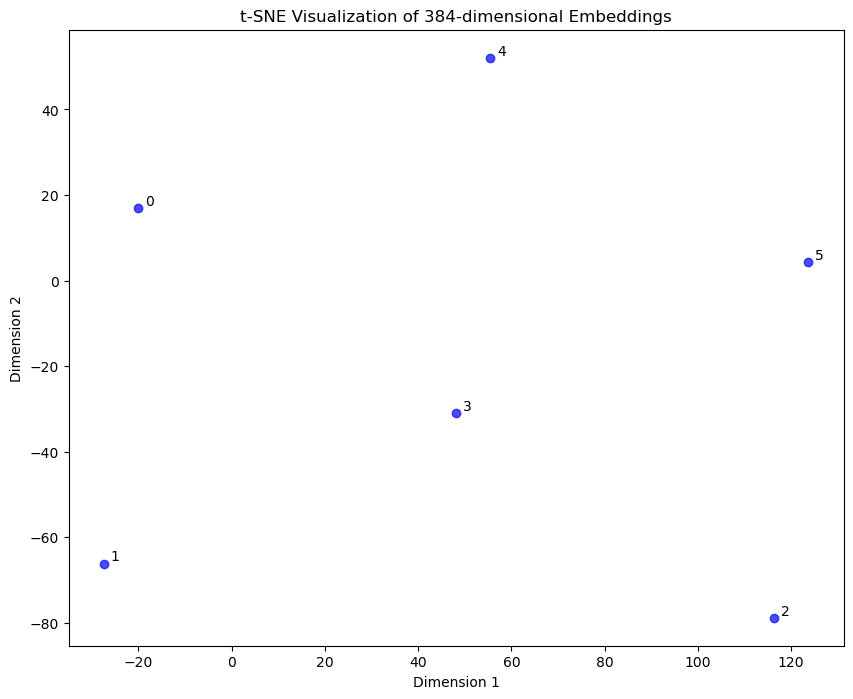

In [31]:
visualize_embeddings(embeddings_2d[:-1])

We'll also locate our **<span style="color: red">question</span>** is in this vector space.

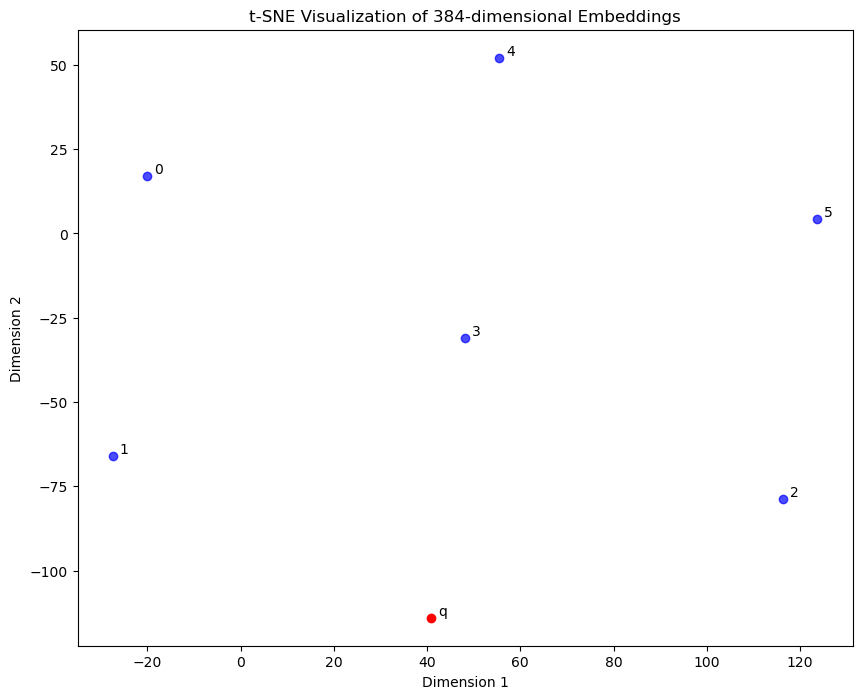

In [32]:
visualize_embeddings(embeddings_2d, True)


Next, we need to find the chunks of text that are semantically closer to our question. These are the pieces of text that are more likely to contain the answers to our question.

There are various approaches to achieve this, and we will use the **Euclidean Distance** to measure the similarity/closeness of data points.

To do this, we will use the **Nearest Neighbors** algorithm and find the top `k` data points that are closest to our question. In our example, we will retrieve the top 5 data points by default.

In [33]:
nn_2d = NearestNeighbors(n_neighbors=5)
nn_2d.fit(embeddings_2d[:-1])

NearestNeighbors()

In [34]:
neighbors = nn_2d.kneighbors(embeddings_2d[-1].reshape(1, -1), return_distance=False)
neighbors

array([[2, 1, 3, 0, 5]])

Let's now plot the closest points as **<span style="color: purple">purple</span>**.

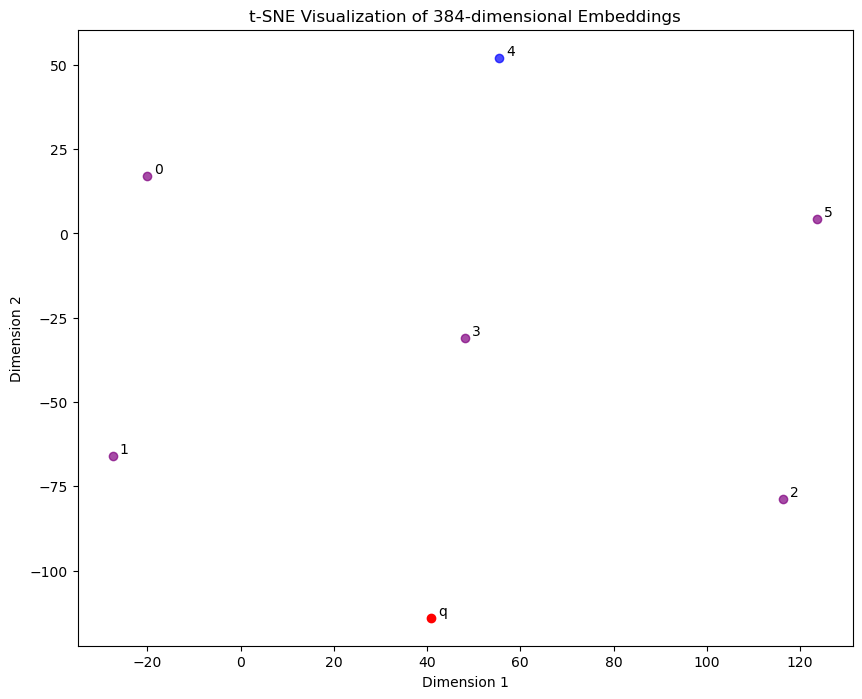

In [35]:
visualize_embeddings(embeddings_2d, True, neighbors)

## Semantic Search

As t-SNE is a non-linear algorithm and we lose some information during this process, we will not use the 2-dimensional vectors - those were used solely for visualization purposes.

We will repeat the same process as above but with the full 384-dimensional vectors instead.

Let's fit our Nearest Neighbors algorithm again, using the full-sized embeddings.

In [36]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(embeddings)

NearestNeighbors()

We will once again convert our question into Embeddings.

In [37]:
question = 'How many people does this pie serve?'
# question = 'What are edible flowers?'
emb_question = emb_function([question])

And, finally, find the chunks of text that are the closest to our question.

In [38]:
neighbors = nn.kneighbors(emb_question, return_distance=False)
neighbors

array([[4, 0, 3, 1, 2]])

This way, we have the **top 5** chunks of text that are most likely to answer our question.

In [39]:
topn_chunks = [chunks[i] for i in neighbors.tolist()[0]]

## Prompt Building

Now, it is time to build our prompt.

Remember that we need to pass our context to it. In this case, we are calling our context *"Search results"* - the name doesn't really matter; the idea is the same.

We will iterate over our top chunks and append them to the prompt.

Finally, we will provide instructions to our model, ask our question, and receive our answer.

In [40]:
def build_prompt(question):
    prompt = ""
    prompt += 'Search results:\n'
    
    for c in topn_chunks:
        prompt += c + '\n\n'
    
    prompt += "Instructions: Compose a comprehensive reply to the query using the search results given. "\
            "Cite each reference using [Page Number] notation (every result has this number at the beginning). "\
            "Citation should be done at the end of each sentence. If the search results mention multiple subjects "\
            "with the same name, create separate answers for each. Only include information found in the results and "\
            "don't add any additional information. Make sure the answer is correct and don't output false content. "\
            "If the text does not relate to the query, simply state 'Found Nothing'. Ignore outlier "\
            "search results which has nothing to do with the question. Only answer what is asked. The "\
            "answer should be short and concise." 
    
    prompt += f"\n\n\nQuery: {question}\n\nAnswer: "
    
    return prompt

In [41]:
prompt = build_prompt(question)
print(prompt)

Search results:
[Page no. 2] "desired.  
 
8. In a small bowl, whisk the egg and cr eam to blend. Using a pastry brush, lightly brush the 
tops of the pies with the egg -cream mixture.  
 
9. Place the pies on the preheated baking sheet in the oven and bake for about 40 minutes, 
or until the crust is deep golden and the filling is bubbling. I f the crust begins to brown before 
the filling bubbles, tent the pies with foil. Let the pies cool on a wire rack until warm before 
serving.  
 
 
Buttery Pastry Dough  
 
Prep Time: 10 minu tes, plus 30 minutes chilling time   
 
Makes:  Enough for 12 individual meat pies  
 
Ingredients:  
 2 ½ cups all -purpose flour  
 1 tablespoon sugar  
 ½ teaspoon fine sea salt or table salt  
 ½"

[Page no. 1] "Curtis Stone’s Meat Pie  Recipe  
 
Serves  6 | Prep Time:  30 minutes | Cook Time:  1 hour and 45 minutes  
 
Ingredients : 
 
 1 ¼ cup extra -virgin olive oil  
 1 small yellow onion, finely chopped  
 1 celery stalk, finely chopped  


# watsonx.ai Inference

To complete our application, all we need to do now is send our prompt to our model and receive its answer based on the content we provided.

We will configure our environment with our credentials, define a helper function, and finally make inferences.

In [ ]:
api_key = 'S6P8WbAt9-KR-P5zQQ-6W8h0UqfZZuD3-u9oaiOsT6Uu'
ibm_cloud_url = "https://eu-de.ml.cloud.ibm.com"
project_id = "00e43b61-b7a6-4ed9-aabf-3650f23d4b91"

In [42]:
# Config watsonx.ai environment - Cloud Version
creds = {
    "url": ibm_cloud_url,
    "apikey": api_key 
}

In [43]:
def send_to_watsonxai(prompts,
                    model_name="google/flan-ul2",
                    decoding_method="greedy",
                    max_new_tokens=100,
                    min_new_tokens=30,
                    temperature=1.0,
                    repetition_penalty=2.0
                    ):
    '''
   helper function for sending prompts and params to Watsonx.ai
    
    Args:  
        prompts:list list of text prompts
        decoding:str Watsonx.ai parameter "sample" or "greedy"
        max_new_tok:int Watsonx.ai parameter for max new tokens/response returned
        temperature:float Watsonx.ai parameter for temperature (range 0>2)
        repetition_penalty:float Watsonx.ai parameter for repetition penalty (range 1.0 to 2.0)

    Returns: None
        prints response
    '''


    # Instantiate parameters for text generation
    model_params = {
        GenParams.DECODING_METHOD: decoding_method,
        GenParams.MIN_NEW_TOKENS: min_new_tokens,
        GenParams.MAX_NEW_TOKENS: max_new_tokens,
        GenParams.RANDOM_SEED: 42,
        GenParams.TEMPERATURE: temperature,
        GenParams.REPETITION_PENALTY: repetition_penalty,
    }


    # Instantiate a model proxy object to send your requests
    model = Model(
        model_id=model_name,
        params=model_params,
        credentials=creds,
        project_id=project_id)


    for prompt in prompts:
        print(model.generate_text(prompt))


Below, we have a few examples of questions to use with both PDF files available.

Feel free to choose any of them or come up with your own questions to test your new application!

In [44]:
# Example questions for the paper:
#   Summarize the irrigation and biotechnology of this paper
#   What are edible flowers?
#   Summarize the conclusion of this study:
#   What is the main conclusion of the study?

# Example questions for the recipe:
#   Summarize this recipe process
#   How many people does this pie serve?
#   How many eggs are necessary to make this pie?

question = "Summarize this recipe process"
prompt = build_prompt(question)

send_to_watsonxai(prompts=[prompt], min_new_tokens=1)

[Page no. 1] "To assemble the pies:  All-purpose flour, for dusting  Buttery Pastry Dough (see recipe below ), shaped into 12 disks and chilled  1 large egg  1 tablespoon heavy cream To make the filling: 1. Heat a large heavy pot over medium -high heat. Add the oil, then add the onion, celery, and carrot and sauté for about 5 minutes,
